In [75]:
import pickle
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import torch
import os

from policy import DPAgent
from new_new_policy import DiscretizedDPAgent
from simulation import Simulator, CustomerGenerator
from hazard_models import ExponentialHazard
from utility_learner import ProjectedVolumeLearner, diam
from degradation_learner import DegradationLearner
from datetime import datetime
from pytz import timezone

from utils import unit_ball_rejection_sample, correct_signs
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import gaussian_kde

import logging
logging.basicConfig(level=logging.INFO)
from tqdm.notebook import tqdm

np.set_printoptions(suppress=True)

In [2]:
# --- 2. Define Sampling Functions ---
# def context_sampler() -> np.ndarray:
#     """Samples a customer's context vector from a uniform distribution."""
#     return np.random.uniform(low=0.0, high=1.0, size=D)

def context_sampler() -> np.ndarray:
    """Samples a customer's context vector uniformly from the unit ball."""
    return np.abs(unit_ball_rejection_sample(D))

def rental_sampler() -> float:
    """Samples a customer's desired rental duration from an exponential distribution."""
    return np.random.exponential(scale=10.0)

def interarrival_sampler() -> float:
    """Samples the time until the next customer arrives."""
    return np.random.exponential(scale=5.0)

# --- 1. Simulation Configuration ---
D = 4                                  # Dimension of context vectors
LAMBDA_VAL = 0.001                     # Baseline hazard constant
NUM_CUSTOMERS = 40000                   # Total number of customers to simulate, i.e. T

# Set a random seed for reproducibility
# np.random.seed(41)

# Ground truth vectors
THETA_TRUE = np.array([0.5, 0.2, 0.4, 0.3])#$, 0.4])    # For degradation
UTILITY_TRUE = np.array([0.372450167, 0.10850869, 0.33930126, 0.71356037])

# context_sampler()  # For customer's willingness to pay

# --- Machine's Pricing Vector 'r' ---
# This is a fallback pricing vector, when we don't feed u_hat to calculate_price
PRICING_R = np.zeros(D)

usage_exp_hazard_model = ExponentialHazard(lambda_val=LAMBDA_VAL)
# spontaneous_exp_hazard_model = None # ExponentialHazard(lambda_val=0.01)

customer_gen = CustomerGenerator(
    d=D,
    context_sampler=context_sampler,
    rental_sampler=rental_sampler,
    interarrival_sampler=interarrival_sampler
)

centroid_params = {
    # 'num_samples': 2000,
    # 'thin': None,
    # 'burn_in': 500 * D ** 2,
    # 'tol': 1e-4,
    # 'rho_target': 0.01
}

termination_rule = lambda diameter: diameter < 0.0005  # Example custom termination rule

projected_volume_learner = ProjectedVolumeLearner(
    T=NUM_CUSTOMERS, 
    d=D, 
    centroid_params=centroid_params,
    incentive_constant=1.1,
    termination_rule=termination_rule,
)

mdp_params = {
    'duration_lambda': 10.0,
    'interarrival_lambda': 5.0,
    'replacement_cost': 1.5,   # Cost to replace the machine
    'failure_cost': 0.75,      # Additional penalty for in-service failure
    'holding_cost_rate': 0.02,   # Cost per unit of idle time
    'gamma': 0.99,             # Discount factor
    'learning_rate': 1e-3,      # Learning rate for the Adam optimizer
    'target_update_freq': 10    # How often to update the target network (in iterations)
}

training_hyperparams = {
    # For FQI
    'num_iterations': 1, # Number of training iterations per policy update
    'dataset_size': 50000,      # Number of transitions to generate for the offline dataset
    'batch_size': 256,           # Batch size for training

    # For discrete DP
    # 'N': [80, 20, 60, 150], # grid sizes [cum_context, context, duration, active_time
    'N': [100, 50, 100, 100], # grid sizes [cum_context, context, revenue, duration]
    'max_cumulative_context': 8.0,
    # 'max_active_time': 150.0,
    'num_value_iterations': 100,
    
}

policy_type = 'decaying_epsilon_greedy'
policy_kwargs = {
    'current_epsilon': 0.10,
    'decay_rate': 0.95,
    'step': 0,
}

In [3]:
def calculate_rolling_rate(df, time_col, value_col, window_size):
    """
    Calculates the rate of a value over a rolling time window on irregular time series data.
    For early time steps, the window size is adaptive, looking back only to time 0.

    Args:
        df (pd.DataFrame): The input dataframe.
        time_col (str): The name of the column with time data.
        value_col (str): The name of the column with values to aggregate (e.g., 'net_profit').
        window_size (int): The maximum duration of the rolling time window.

    Returns:
        pd.Series: A series containing the calculated rolling rate for each row.
    """
    # Ensure the dataframe is sorted by time, which is crucial.
    df = df.sort_values(time_col).reset_index(drop=True)
    
    times = df[time_col].values
    values = df[value_col].values
    
    # --- MODIFICATION 1: Cap the start time at 0 ---
    # For each end time `t_i`, find the start time `max(0, t_i - window)`.
    start_times = np.maximum(0, times - window_size)
    
    # Use searchsorted to find the index where each start_time would be inserted.
    start_indices = np.searchsorted(times, start_times, side='left')
    
    # Use a cumulative sum to efficiently calculate the sum over any slice [j, i].
    value_cumsum = np.cumsum(values)
    shifted_cumsum = np.concatenate(([0], value_cumsum[:-1]))
    window_sums = value_cumsum - shifted_cumsum[start_indices]
    
    # --- MODIFICATION 2: Use the actual window duration as the denominator ---
    # The duration is the current time minus the actual start time of the window.
    actual_window_durations = times - start_times
    
    # Initialize profit_rate array to handle potential division by zero
    profit_rate = np.zeros_like(times, dtype=float)
    
    # Create a mask to avoid division by zero where the duration is 0 (e.g., at the very first data point if time=0)
    non_zero_duration_mask = actual_window_durations > 0
    
    # Calculate rate only for non-zero durations
    profit_rate[non_zero_duration_mask] = window_sums[non_zero_duration_mask] / actual_window_durations[non_zero_duration_mask]
    
    return pd.Series(profit_rate, index=df.index)

In [133]:
list_of_utility_updates = []
list_of_theta_updates = []
for file in os.listdir('models'):
    if file.startswith('simulator_') and not file.endswith('discrete_policy.pkl'):
        sim = Simulator.load('models/'+file[:-4])
        list_of_theta_updates.append(sim.theta_updates)
        list_of_utility_updates.append(sim.utility_updates)

all_theta_data = []
for ind, thta_update in enumerate(list_of_theta_updates):
    theta_data = []
    for d in thta_update:
        idx, diff = d['customer_idx'], d['theta_hat'] - THETA_TRUE
        l2, linf= np.linalg.norm(diff, 2), np.linalg.norm(diff, np.inf)
        theta_data.append({'customer_idx': idx, 'l2_error': l2, 'linf_error': linf})
    all_theta_data.append(pd.DataFrame(theta_data))
    
all_utility_data = []
for ind, util_update in enumerate(list_of_utility_updates):
    util_data = []
    for d in util_update:
        idx, diff = d['customer_idx'], d['u_hat'] - UTILITY_TRUE
        l2, linf= np.linalg.norm(diff, 2), np.linalg.norm(diff, np.inf)
        util_data.append({'customer_idx': idx, 'l2_error': l2, 'linf_error': linf})
    all_utility_data.append(pd.DataFrame(util_data))

INFO:root:Simulation state loaded from models/simulator_20250915_185144.


Discretization setup:
  - Cumulative Context (cc):    100 steps up to 8.00
  - Cust. Degradation (cx):     50 steps up to 1.00
  - Cust. Revenue (cu):         100 steps up to 1.00 (99.9th percentile)
  - Rental Duration (T):        100 steps up to 76.01 (99.95th percentile)
Pre-computing expectations from 100000 customer samples...
Starting Numba-accelerated pre-computation of arrival dynamics...


INFO:root:Simulation state loaded from models/simulator_20250915_214357.


Pre-computation complete. ✅
Discretization setup:
  - Cumulative Context (cc):    100 steps up to 8.00
  - Cust. Degradation (cx):     50 steps up to 1.00
  - Cust. Revenue (cu):         100 steps up to 1.00 (99.9th percentile)
  - Rental Duration (T):        100 steps up to 76.01 (99.95th percentile)
Pre-computing expectations from 100000 customer samples...
Starting Numba-accelerated pre-computation of arrival dynamics...


INFO:root:Simulation state loaded from models/simulator_20250915_195120.


Pre-computation complete. ✅
Discretization setup:
  - Cumulative Context (cc):    100 steps up to 8.00
  - Cust. Degradation (cx):     50 steps up to 1.00
  - Cust. Revenue (cu):         100 steps up to 1.00 (99.9th percentile)
  - Rental Duration (T):        100 steps up to 76.01 (99.95th percentile)
Pre-computing expectations from 100000 customer samples...
Starting Numba-accelerated pre-computation of arrival dynamics...


INFO:root:Simulation state loaded from models/simulator_20250916_095648.


Pre-computation complete. ✅
Discretization setup:
  - Cumulative Context (cc):    100 steps up to 8.00
  - Cust. Degradation (cx):     50 steps up to 1.00
  - Cust. Revenue (cu):         100 steps up to 1.00 (99.9th percentile)
  - Rental Duration (T):        100 steps up to 76.01 (99.95th percentile)
Pre-computing expectations from 100000 customer samples...
Starting Numba-accelerated pre-computation of arrival dynamics...


INFO:root:Simulation state loaded from models/simulator_20250915_195137.


Pre-computation complete. ✅
Discretization setup:
  - Cumulative Context (cc):    100 steps up to 8.00
  - Cust. Degradation (cx):     50 steps up to 1.00
  - Cust. Revenue (cu):         100 steps up to 1.00 (99.9th percentile)
  - Rental Duration (T):        100 steps up to 76.01 (99.95th percentile)
Pre-computing expectations from 100000 customer samples...
Starting Numba-accelerated pre-computation of arrival dynamics...


INFO:root:Simulation state loaded from models/simulator_20250915_195045.


Pre-computation complete. ✅
Discretization setup:
  - Cumulative Context (cc):    100 steps up to 8.00
  - Cust. Degradation (cx):     50 steps up to 1.00
  - Cust. Revenue (cu):         100 steps up to 1.00 (99.9th percentile)
  - Rental Duration (T):        100 steps up to 76.01 (99.95th percentile)
Pre-computing expectations from 100000 customer samples...
Starting Numba-accelerated pre-computation of arrival dynamics...


INFO:root:Simulation state loaded from models/simulator_20250915_195104.


Pre-computation complete. ✅
Discretization setup:
  - Cumulative Context (cc):    100 steps up to 8.00
  - Cust. Degradation (cx):     50 steps up to 1.00
  - Cust. Revenue (cu):         100 steps up to 1.00 (99.9th percentile)
  - Rental Duration (T):        100 steps up to 76.01 (99.95th percentile)
Pre-computing expectations from 100000 customer samples...
Starting Numba-accelerated pre-computation of arrival dynamics...


INFO:root:Simulation state loaded from models/simulator_20250915_214349.


Pre-computation complete. ✅
Discretization setup:
  - Cumulative Context (cc):    100 steps up to 8.00
  - Cust. Degradation (cx):     50 steps up to 1.00
  - Cust. Revenue (cu):         100 steps up to 1.00 (99.9th percentile)
  - Rental Duration (T):        100 steps up to 76.01 (99.95th percentile)
Pre-computing expectations from 100000 customer samples...
Starting Numba-accelerated pre-computation of arrival dynamics...


INFO:root:Simulation state loaded from models/simulator_20250915_185203.


Pre-computation complete. ✅
Discretization setup:
  - Cumulative Context (cc):    100 steps up to 8.00
  - Cust. Degradation (cx):     50 steps up to 1.00
  - Cust. Revenue (cu):         100 steps up to 1.00 (99.9th percentile)
  - Rental Duration (T):        100 steps up to 76.01 (99.95th percentile)
Pre-computing expectations from 100000 customer samples...
Starting Numba-accelerated pre-computation of arrival dynamics...


INFO:root:Simulation state loaded from models/simulator_20250915_214415.


Pre-computation complete. ✅
Discretization setup:
  - Cumulative Context (cc):    100 steps up to 8.00
  - Cust. Degradation (cx):     50 steps up to 1.00
  - Cust. Revenue (cu):         100 steps up to 1.00 (99.9th percentile)
  - Rental Duration (T):        100 steps up to 76.01 (99.95th percentile)
Pre-computing expectations from 100000 customer samples...
Starting Numba-accelerated pre-computation of arrival dynamics...
Pre-computation complete. ✅


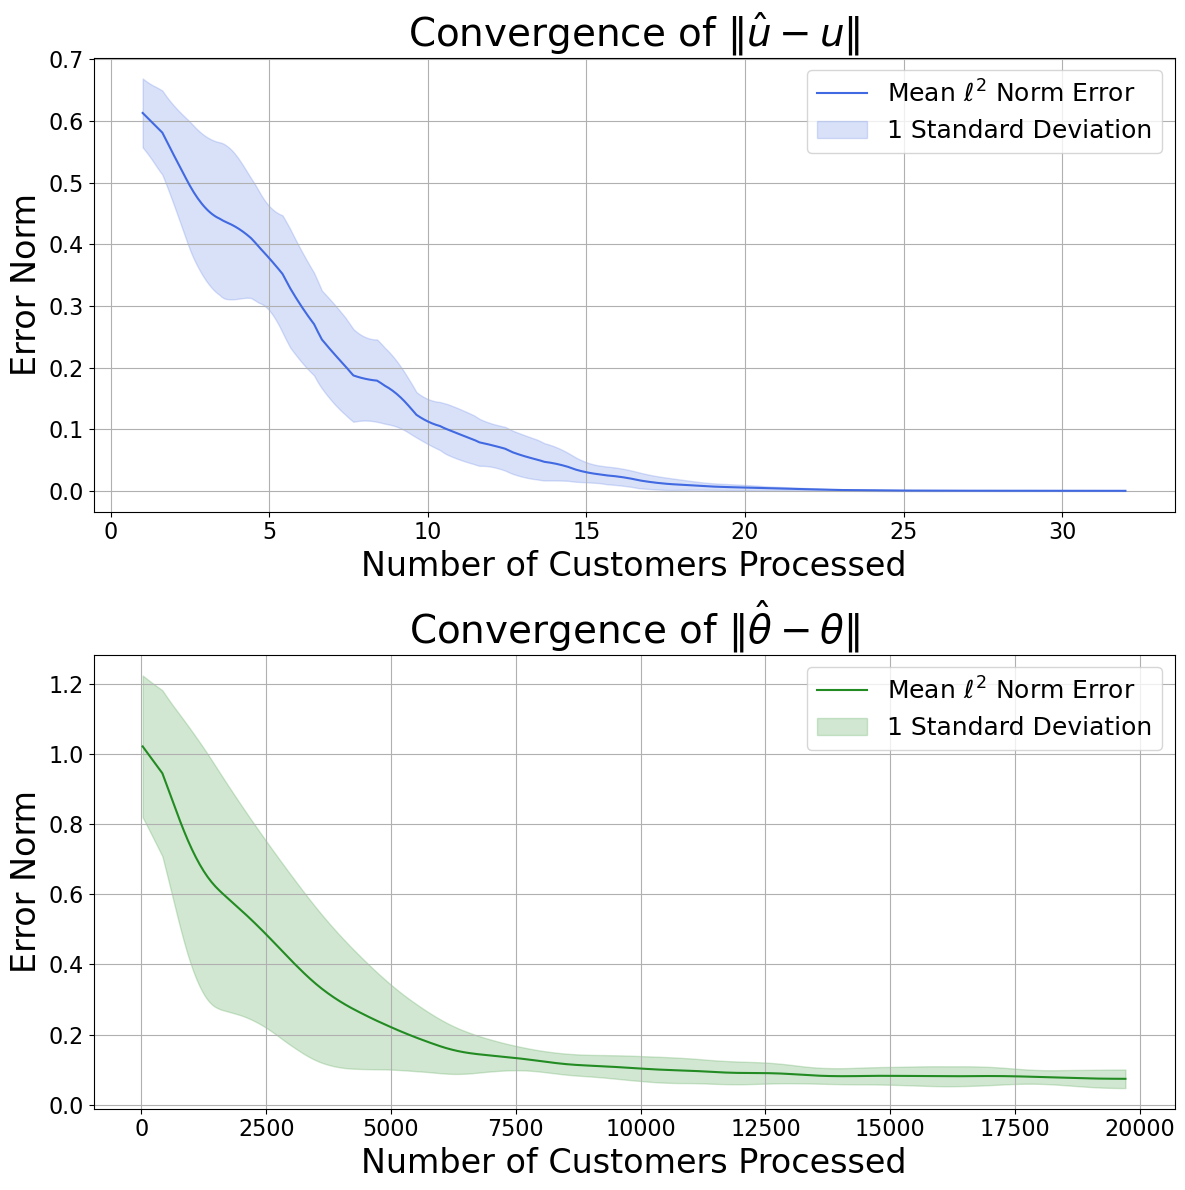

In [138]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def process_and_plot_convergence(ax, all_data, title, color):
    """
    Processes a list of simulation dataframes and plots the smoothed
    mean and standard deviation on a given matplotlib axis.

    Args:
        ax (matplotlib.axes.Axes): The axis object to plot on.
        all_data (list): A list of pandas DataFrames from simulation runs.
        title (str): The title for the subplot.
        color (str): The color to use for the plot lines and shading.
    """
    # --- 1. Resample all trajectories onto a common x-axis ---
    min_x = min(df['customer_idx'].min() for df in all_data)
    max_x = max(df['customer_idx'].max() for df in all_data)
    common_x_axis = np.linspace(min_x, max_x, 500)
    
    resampled_errors = []
    for data in all_data:
        resampled_error = np.interp(
            common_x_axis,
            data['customer_idx'],
            data['l2_error']
        )
        resampled_errors.append(resampled_error)

    error_matrix = np.vstack(resampled_errors)
    mean_error = np.mean(error_matrix, axis=0)
    std_error = np.std(error_matrix, axis=0)

    # --- 2. Smoothen the curves ---
    smoothing_window = 20
    smooth_mean_error = pd.Series(mean_error).rolling(window=smoothing_window, center=True, min_periods=1).mean()
    smooth_std_error = pd.Series(std_error).rolling(window=smoothing_window, center=True, min_periods=1).mean()

    # --- 3. Plot on the provided axis ---
    ax.plot(common_x_axis, smooth_mean_error, label='Mean $\ell^2$ Norm Error', color=color)
    ax.fill_between(
        common_x_axis,
        smooth_mean_error - smooth_std_error,
        smooth_mean_error + smooth_std_error,
        color=color,
        alpha=0.2,
        label='1 Standard Deviation'
    )
    
    # set tick font size
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    ax.set_xlabel('Number of Customers Processed', fontsize=24)
    ax.set_ylabel('Error Norm', fontsize=24)
    ax.set_title(title, fontsize=28)
    ax.legend(fontsize=18)
    ax.grid(True)


# --- Main plotting logic ---

# Assume 'all_utility_data' and 'all_theta_data' are loaded
# For example:
# all_utility_data = [pd.read_csv(f) for f in utility_files]
# all_theta_data = [pd.read_csv(f) for f in theta_files]

# Create a figure with 2 rows and 1 column of subplots.
# `figsize` controls the overall size of the combined image.
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plot the first dataset on the top subplot (axes[0])
process_and_plot_convergence(
    ax=axes[0], 
    all_data=all_utility_data, 
    title=r'Convergence of $\|\hat u - u\|$', 
    color='royalblue'
)

plot_theta_data = [df[df.customer_idx <= 20000].reset_index(drop=True).copy() for df in all_theta_data]

# Plot the second dataset on the bottom subplot (axes[1])
process_and_plot_convergence(
    ax=axes[1], 
    all_data=plot_theta_data, 
    title=r'Convergence of $\|\hat \theta - \theta\|$', 
    color='forestgreen'
)

# Adjust the layout to prevent titles and labels from overlapping
plt.tight_layout()

# Save the combined figure
plt.savefig('figures/combined_convergence.pdf')
plt.show()

In [57]:
df = all_theta_data[0]

df[df.customer_idx <= 20000]

,customer_idx,l2_error,linf_error
0,25,1.229995,0.891491
1,1223,0.707774,0.648699
2,2254,0.597341,0.526382
3,3207,0.514540,0.473463
4,4171,0.534808,0.512017
5,5252,0.468202,0.453298
6,6254,0.508943,0.480102
7,7265,0.522476,0.484164
8,8389,0.524278,0.485035
9,9461,0.520264,0.473004


In [4]:
window_duration = 10000 # Define the time window for the rolling rate

simulation_dfs = []
# use os module to find all csv files starting with 'data/simulation_data_'
for file in os.listdir('data'):
    if file.startswith('simulation_data_') and file.endswith('.csv'):
        df = pd.read_csv(os.path.join('data', file))
        df['net_profit'] = df['profit'] + df['loss']
        df['profit_rate'] = calculate_rolling_rate(df, 'calendar_time', 'net_profit', window_duration)
        simulation_dfs.append(df)

In [5]:
optimal_dfs = pd.read_csv('data/optimal_trajectories.csv')

optimal_rev_dfs = []
for i in optimal_dfs.run_id.unique():
    df = optimal_dfs[optimal_dfs.run_id == i].reset_index(drop=True).copy()
    df['calendar_time'] = df['calendar_time'] - df['calendar_time'].min()  # Normalize time to start from 0
    df['net_profit'] = df['profit'] + df['loss']
    df['profit_rate'] = calculate_rolling_rate(df, 'calendar_time', 'net_profit', window_duration)
    optimal_rev_dfs.append(df)

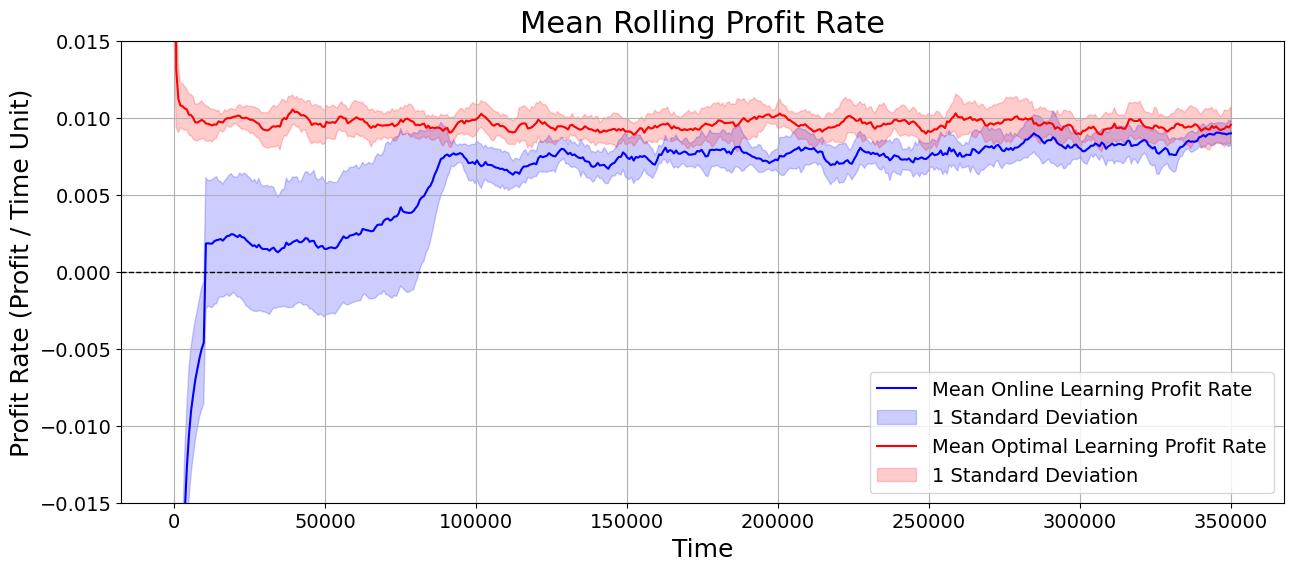

In [136]:
# Determine the overall time range for the common grid
min_time = min(df['calendar_time'].min() for df in simulation_dfs)

min_time = 25
max_time = min(
            max(df['calendar_time'].max() for df in simulation_dfs),
            max(df['calendar_time'].max() for df in optimal_rev_dfs)
        )
max_time = 350000

# Create a uniform time grid. 500 points is usually a good resolution.
common_time_grid = np.linspace(min_time, max_time, 500)

# A list to store the profit rate of each run, interpolated onto the common grid
online_resampled_profit_rates = []
for sim_df in simulation_dfs:
    # For each simulation, interpolate its profit_rate onto the common_time_grid
    # np.interp(new_x, old_x, old_y)
    resampled_rate = np.interp(
        common_time_grid, 
        sim_df['calendar_time'], 
        sim_df['profit_rate']
    )
    online_resampled_profit_rates.append(resampled_rate)
# --- 2. Calculate the mean and standard deviation across all runs ---
# Convert the list of arrays into a 2D NumPy array for easy computation
# Each row is a simulation run, each column is a time point
online_profit_rate_matrix = np.vstack(online_resampled_profit_rates)
# Calculate the mean and standard deviation down each column (axis=0)
online_mean_profit_rate = np.mean(online_profit_rate_matrix, axis=0)
online_std_profit_rate = np.std(online_profit_rate_matrix, axis=0)



# A list to store the profit rate of each run, interpolated onto the common grid
optimal_resampled_profit_rates = []
for sim_df in optimal_rev_dfs:
    # For each simulation, interpolate its profit_rate onto the common_time_grid
    # np.interp(new_x, old_x, old_y)
    resampled_rate = np.interp(
        common_time_grid, 
        sim_df['calendar_time'], 
        sim_df['profit_rate']
    )
    optimal_resampled_profit_rates.append(resampled_rate)
# --- 2. Calculate the mean and standard deviation across all runs ---
# Convert the list of arrays into a 2D NumPy array for easy computation
# Each row is a simulation run, each column is a time point
optimal_profit_rate_matrix = np.vstack(optimal_resampled_profit_rates)
# Calculate the mean and standard deviation down each column (axis=0)
optimal_mean_profit_rate = np.mean(optimal_profit_rate_matrix, axis=0)
optimal_std_profit_rate = np.std(optimal_profit_rate_matrix, axis=0)


# --- 3. Plot the average trajectory with the shaded standard deviation ---

plt.figure(figsize=(15, 6))

# Plot the average trajectory
plt.plot(common_time_grid, online_mean_profit_rate, label='Mean Online Learning Profit Rate', color='blue')

# Add the shaded area for the standard deviation (mean +/- 1 std)
plt.fill_between(
    common_time_grid,
    online_mean_profit_rate - online_std_profit_rate,
    online_mean_profit_rate + online_std_profit_rate,
    color='blue',
    alpha=0.2, # Use transparency to make it look nice
    label='1 Standard Deviation'
)

# Plot the average trajectory
plt.plot(common_time_grid, optimal_mean_profit_rate, label='Mean Optimal Learning Profit Rate', color='red')

# Add the shaded area for the standard deviation (mean +/- 1 std)
plt.fill_between(
    common_time_grid,
    optimal_mean_profit_rate - optimal_std_profit_rate,
    optimal_mean_profit_rate + optimal_std_profit_rate,
    color='red',
    alpha=0.2, # Use transparency to make it look nice
    label='1 Standard Deviation'
)

plt.xlabel('Time', fontsize=18)
plt.ylabel('Profit Rate (Profit / Time Unit)', fontsize=18)

plt.ylim(top=0.015, bottom=-0.015)

# set x, y axes font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# insert horizontal line at y=0
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.title(f'Mean Rolling Profit Rate', fontsize=22)
plt.legend(fontsize=14)
plt.grid(True)
plt.savefig('figures/average_profit_rate_comparison.pdf')
plt.show()

### Plotting optimal policy

In [63]:
class PerfectDegradationLearner:
    def __init__(self, d, theta_true, hazard_model):
        self.d = d
        self.theta_true = theta_true
        self.hazard_model = hazard_model  # Placeholder, not used
        
    def get_theta(self):
        return self.theta_true
    
    def cum_baseline(self, t):
        return self.hazard_model.Lambda_0(t)
    
    def inverse_cum_baseline(self, u):
        return self.hazard_model.Lambda_0_inverse(u)

In [64]:
# perfect_dpagent.run_value_iteration(100)
# perfect_dpagent.save_policy('models/perfect_discrete_policy.pkl')

In [65]:
perfect_dpagent = DiscretizedDPAgent.load_policy('models/perfect_discrete_policy.pkl')

Discretization setup:
  - Cumulative Context (cc):    100 steps up to 8.00
  - Cust. Degradation (cx):     50 steps up to 1.00
  - Cust. Revenue (cu):         100 steps up to 1.00 (99.9th percentile)
  - Rental Duration (T):        100 steps up to 76.01 (99.95th percentile)
Pre-computing expectations from 100000 customer samples...
Starting Numba-accelerated pre-computation of arrival dynamics...
Pre-computation complete. ✅


/var/folders/k0/fk1yjsp11fg_7yjml4xg3kmc0000gn/T/ipykernel_71903/1463124029.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.9, 1.02]) # rect=[left, bottom, right, top]


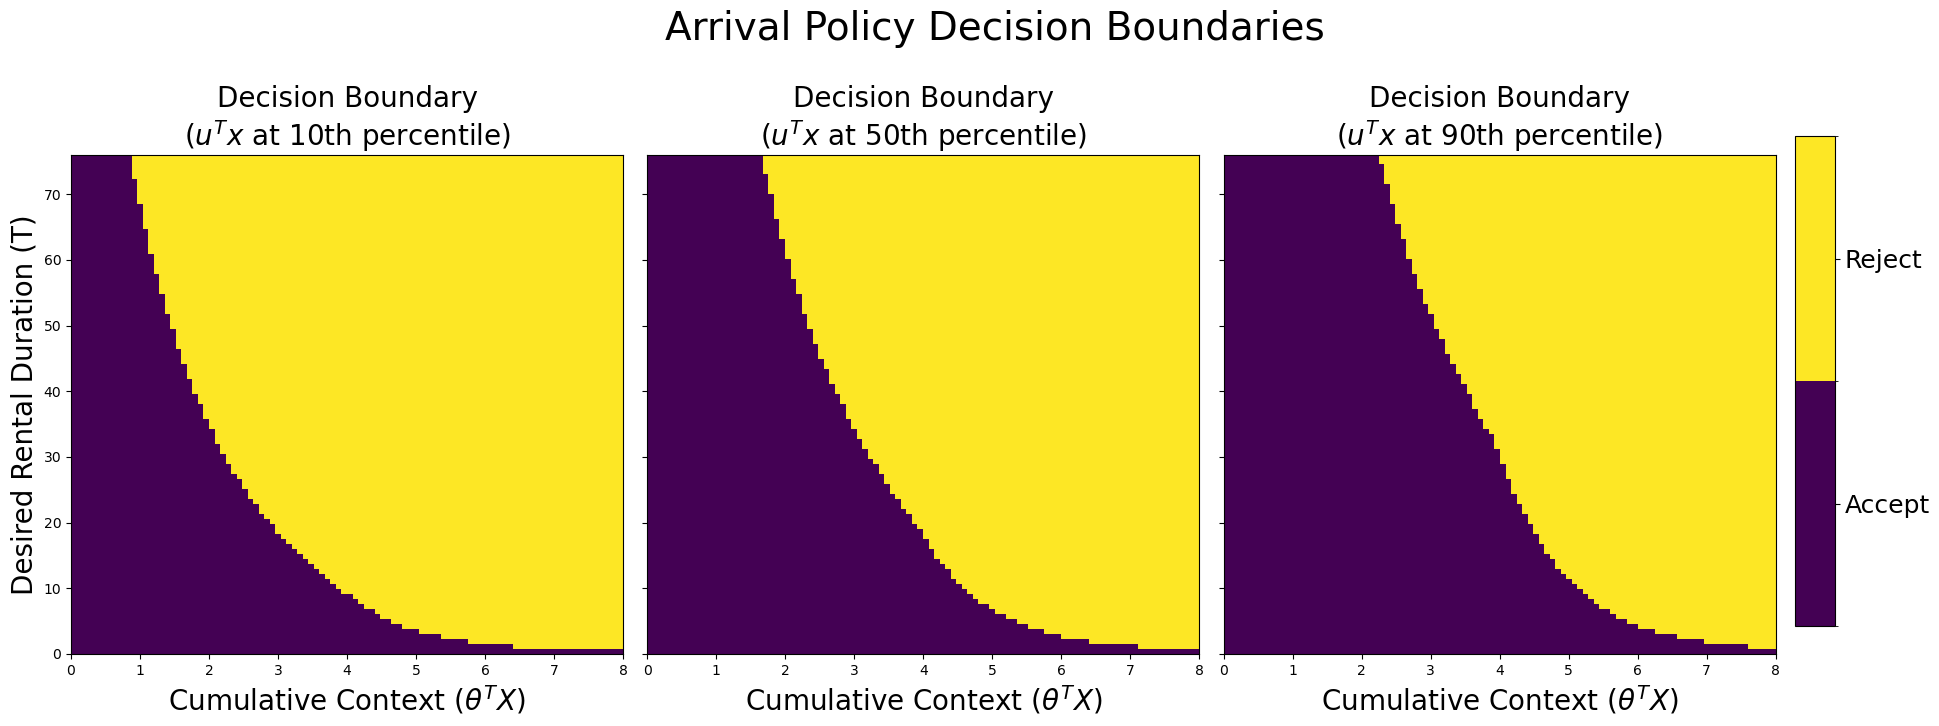

In [139]:
def compute_arrival_decision_grid(ddpa, fixed_customer_context, grid_resolution=75):
    """
    Computes the deterministic action for a grid of cumulative context vs. duration.
    (This function remains unchanged)
    """
    cumulative_context_grid = np.linspace(0, ddpa.grid_max_vals[0], grid_resolution)
    duration_grid = np.linspace(0, ddpa.grid_max_vals[3], grid_resolution)
    action_grid = np.zeros((grid_resolution, grid_resolution), dtype=int)
    
    for i, cum_context in enumerate(cumulative_context_grid):
        for j, duration in enumerate(duration_grid):
            state_tuple = (cum_context, 0, fixed_customer_context, duration)
            state_indices = ddpa._get_state_indices(state_tuple)
            action_grid[j, i] = ddpa.policy_arrival[state_indices]
            
    return action_grid, cumulative_context_grid, duration_grid

# --- Main Plotting Logic ---

# 1. Pre-calculate the customer context values for percentiles
sampled_customers = [customer_gen.generate() for _ in range(10000)]
sampled_cx = np.array([np.dot(perfect_dpagent.theta, c['context']) for c in sampled_customers])
percentiles_to_plot = [10, 50, 90]
cx_percentiles = {p: np.percentile(sampled_cx, p) for p in percentiles_to_plot}

# 2. Create a figure with 1 row and 3 columns of subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharey=True)

# --- CHANGE 1: Define a Purple/Yellow binary colormap ---
cmap = mcolors.ListedColormap(['#440154', '#FDE725']) # Purple, Yellow
bounds = [-0.5, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# 4. Generate and plot a heatmap for each percentile
for i, p in enumerate(percentiles_to_plot):
    ax = axes[i]
    fixed_cx = cx_percentiles[p]
    
    decision_grid, context_axis, duration_axis = compute_arrival_decision_grid(
        perfect_dpagent, 
        fixed_customer_context=fixed_cx, 
        grid_resolution=100
    )

    im = ax.imshow(decision_grid, origin='lower', aspect='auto', cmap=cmap, norm=norm,
                   extent=[context_axis[0], context_axis[-1],
                           duration_axis[0], duration_axis[-1]])
    
    ax.set_xlabel(r'Cumulative Context ($\theta^T X$)', fontsize=20)
    ax.set_title(f'Decision Boundary\n($u^T x$ at {p}th percentile)', fontsize=20)

axes[0].set_ylabel('Desired Rental Duration (T)', fontsize=20)
fig.suptitle('Arrival Policy Decision Boundaries', fontsize=28, y=1.03)


# --- CHANGE 2: Manually position the colorbar outside the plots ---

# Adjust subplot parameters to make space on the right for the colorbar
fig.subplots_adjust(right=0.88)

# Add a new axis for the colorbar [left, bottom, width, height] in figure coordinates
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])

# Create the colorbar on the new axis
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0, 1])
cbar.ax.set_yticklabels(['Accept', 'Reject'], fontsize=18)
# cbar.set_label('Action', fontsize=16)

# --- MODIFICATION: Use tight_layout to adjust spacing ---
# This will automatically adjust spacing to prevent overlap,
# including the suptitle. The rect parameter leaves space for the suptitle and colorbar.
fig.tight_layout(rect=[0, 0, 0.9, 1.02]) # rect=[left, bottom, right, top]

# Save and show the plot
plt.savefig('figures/arrival_policy_side_by_side.pdf', bbox_inches='tight')
plt.show()



--- Generating Departure Policy Plot ---


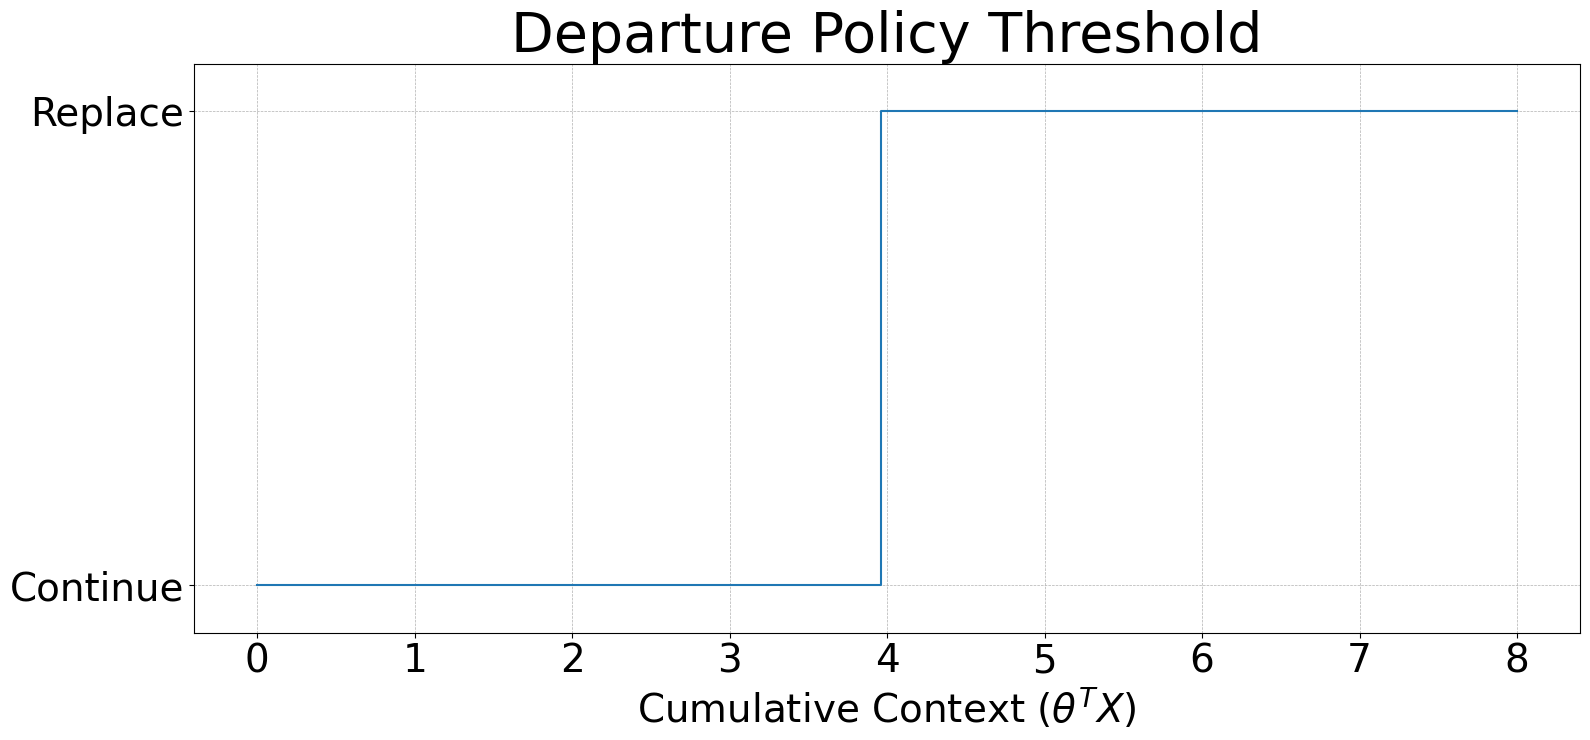

In [144]:
def plot_departure_policy_threshold(ddpa):
    """
    Generates a plot showing the departure policy threshold (Replace vs. No Replace).

    The plot shows the decision for each value of cumulative context,
    while keeping the machine's active time fixed.

    Args:
        ddpa: The trained DiscretizedDPAgent object.
        fixed_active_time_idx (int): The grid index for the fixed active time (t_i).
    """
    # Extract the relevant 1D slice of the policy
    policy_slice = ddpa.policy_departure
    
    # The actions are 2 (replace) and 3 (no_replace). We map them to 0 and 1 for plotting.
    decision = np.where(policy_slice == 2, 1, 0)
    
    # --- Plotting ---
    plt.figure(figsize=(16, 7.5))
    plt.step(ddpa.grids[0], decision, where='post')
    
    # --- Formatting ---
    plt.xlabel(r'Cumulative Context ($\theta^T X$)', fontsize=28)
    # plt.ylabel('Decision', fontsize=18)
    plt.title(f'Departure Policy Threshold', fontsize=40)
    plt.yticks([0, 1], ['Continue', 'Replace'])
    plt.ylim(-0.1, 1.1)
    # set tick font size
    plt.tick_params(axis='both', which='major', labelsize=28)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.savefig('figures/departure_policy_threshold.pdf', bbox_inches='tight')
    plt.tight_layout()
    plt.show()


# 2. Visualize the DEPARTURE policy
print("\n--- Generating Departure Policy Plot ---")
# Let's look at the replacement threshold for a machine of average age
mid_active_time_idx = len(perfect_dpagent.grids[3]) // 2
plot_departure_policy_threshold(perfect_dpagent)